In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt
import warnings

 
warnings.filterwarnings("ignore")
plt.rc('font', family='NanumBarunGothic') 

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **DATA cleansing**

In [ ]:
all = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/all_clean.csv',parse_dates=['STD_YMD'])

In [ ]:
cj = list(all.filter(like='CJ').columns)
gs = list(all.filter(like='GS').columns)
tmst = list(all.filter(like='TMST').columns)
sc = all.drop(cj+gs+tmst, axis = 1) 
amt = list(sc.filter(like='AMT').columns)
sc_cnt = sc.drop(amt,axis=1)
sc_cnt = sc_cnt.query('HDONG_GU =="서울 중구" or HDONG_GU == "서울 노원구"')

In [ ]:
sc_cnt_sum = sc_cnt.groupby('STD_YMD').sum().reset_index()
sc_cnt_sum.columns.values[1:] = list(map(lambda x : x[7:],sc_cnt_sum.columns.values[1:]))

In [ ]:
sc_cnt_sum_19 =sc_cnt_sum[sc_cnt_sum['STD_YMD'] < '2020']
sc_cnt_sum_20 =sc_cnt_sum[sc_cnt_sum['STD_YMD'] > '2020']

sc_cnt_sum_20.index = sc_cnt_sum_20['STD_YMD']
del sc_cnt_sum_20['STD_YMD']

In [ ]:
#correlation heatmap
#plt.figure(figsize=(10,10))
#sns.heatmap(data = sc_cnt_sum_20.corr(method='spearman'), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
#plt.show()

# **2020 clustering**

In [ ]:
sc_cnt_sum_20.head()

,가구,가전,광학제품,레저업소,레저용품,문화취미,보건위생,사무통신,서적문구,수리서비스,숙박,신변잡화,연료판매,요식업소,유통업,음료식품,의료기관,의복,자동차정비,자동차판매,전기,주방용구,직물
STD_YMD,,,,,,,,,,,,,,,,,,,,,,,
2020-02-01,204.0,671.0,479.0,30250.0,9854.0,5849.0,20078.0,78098.0,7113.0,2361.0,5156.0,2313.0,17490.0,409739.0,351581.0,39498.0,66570.0,6757.0,8879.0,117.0,55.0,690.0,355.0
2020-02-02,100.0,482.0,344.0,27583.0,9297.0,3898.0,16218.0,61066.0,5511.0,506.0,4091.0,1382.0,13912.0,336699.0,303473.0,29679.0,13444.0,3646.0,5125.0,4.0,8.0,251.0,70.0
2020-02-03,95.0,755.0,1077.0,21426.0,4976.0,3092.0,12453.0,64203.0,7451.0,2361.0,3664.0,1684.0,15614.0,409252.0,347367.0,42502.0,106777.0,3642.0,8324.0,69.0,28.0,544.0,297.0
2020-02-04,53.0,674.0,699.0,21035.0,4651.0,3429.0,11714.0,65874.0,7239.0,1755.0,3969.0,1627.0,15832.0,416373.0,343032.0,40573.0,85612.0,3487.0,7995.0,144.0,72.0,369.0,372.0
2020-02-05,126.0,609.0,622.0,21784.0,4706.0,4322.0,11811.0,68869.0,7156.0,1969.0,4153.0,1601.0,15744.0,413682.0,339150.0,40217.0,76523.0,3470.0,7711.0,106.0,33.0,508.0,355.0


In [ ]:
sc_cnt_sum_20_roll3 = pd.DataFrame(sc_cnt_sum_20.rolling(3).mean())
sc_cnt_sum_20_roll5 = pd.DataFrame(sc_cnt_sum_20.rolling(5).mean())
sc_cnt_sum_20_roll7 = pd.DataFrame(sc_cnt_sum_20.rolling(7).mean())

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as hac
from scipy import stats
from scipy.cluster.hierarchy import cut_tree

def hclust(data,metric):
  min_max_scaler = MinMaxScaler()
  data_scaled = min_max_scaler.fit_transform(np.array(data))

  data_scaled= pd.DataFrame(data_scaled)
  data_scaled.columns = data.columns
  data_scaled = data_scaled.T

  # Do the clustering
  Z = hac.linkage(data_scaled, method='single', metric=metric)
  
  # Plot dendogram
  plt.figure(figsize=(8, 6))
  plt.title('Hierarchical Clustering Dendrogram',fontsize=20)
  plt.xlabel('sample index')
  plt.ylabel('distance')
  hac.dendrogram(
      Z,
      leaf_rotation=90.,  # rotates the x axis labels
      leaf_font_size=8.,  # font size for the x axis labels
  )
  plt.show()

  return(Z)

## **clustering (method = DTW)**

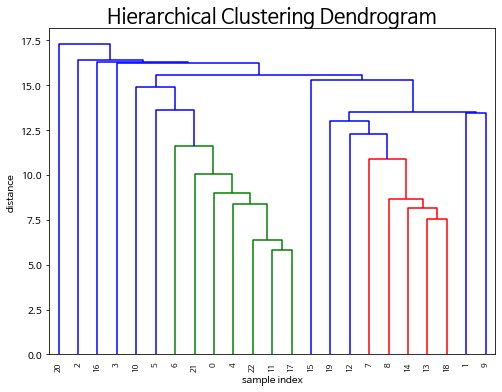

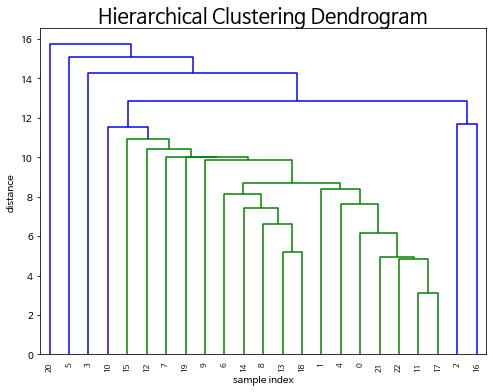

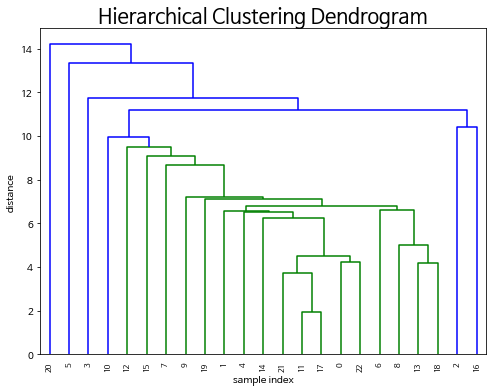

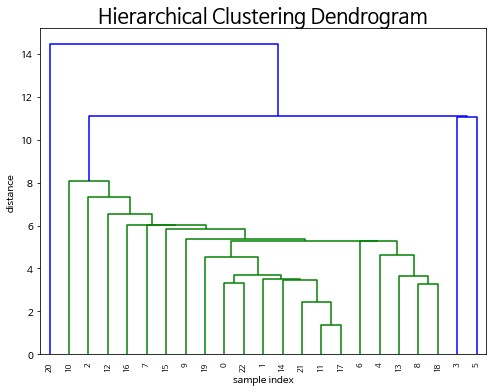

In [ ]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def dtw(x, y):
    d = fastdtw(x, y, dist=euclidean)[0]
    return d 
    
DTW = hclust(sc_cnt_sum_20.dropna(),dtw) # 최종 선택 후, cut tree 진행
DTW_roll3 = hclust(sc_cnt_sum_20_roll3.dropna(),dtw)
DTW_roll5 = hclust(sc_cnt_sum_20_roll5.dropna(),dtw)
DTW_roll7 = hclust(sc_cnt_sum_20_roll7.dropna(),dtw)

In [ ]:
DTW_info = cut_tree(DTW,13)
DTW_info_roll3 = cut_tree(DTW_roll3, 7)
DTW_info_roll5 = cut_tree(DTW_roll5, 5)
DTW_info_roll7 = cut_tree(DTW_roll7, 3)

In [ ]:
#pearson_info = pearson_info.reshape(-1,)
#pearson_info_roll3 = pearson_info_roll3.reshape(-1,)
#pearson_info_roll5 = pearson_info_roll5.reshape(-1,)

DTW_info=DTW_info.reshape(-1,)
DTW_info_roll3=DTW_info_roll3.reshape(-1,)
DTW_info_roll5=DTW_info_roll5.reshape(-1,)
DTW_info_roll7=DTW_info_roll7.reshape(-1,)

In [ ]:
cat = np.array(sc_cnt_sum_20.columns)

In [ ]:
cluster_result = pd.DataFrame({'업종':cat,
                              #'pearson':pearson_info,
                              #'pearson_roll3':pearson_info_roll3,
                              #'pearson_roll5':pearson_info_roll5,
                               'DTW':DTW_info,
                               'DTW_roll3':DTW_info_roll3,
                               'DTW_roll5':DTW_info_roll5,
                               'DTW_roll7':DTW_info_roll7})
cluster_result

,업종,DTW,DTW_roll3,DTW_roll5,DTW_roll7
0,가구,0,0,0,0
1,가전,1,0,0,0
2,광학제품,2,1,1,0
3,레저업소,3,2,2,1
4,레저용품,0,0,0,0
5,문화취미,4,3,3,1
6,보건위생,0,0,0,0
7,사무통신,5,0,0,0
8,서적문구,5,0,0,0
9,수리서비스,6,0,0,0


## **DTW cluster graph**

In [ ]:
#data scaling
def scaler(data):
  min_max_scaler = MinMaxScaler()
  data_scaled = min_max_scaler.fit_transform(np.array(data))

  data_scaled= pd.DataFrame(data_scaled)
  data_scaled.columns = data.columns
  return data_scaled

# kind show
def clustering_plot(cluster,data):
  
  dat = scaler(data)


  legend1 = []
  title=""
  plt.figure(figsize=(6,6))
  for i in range(0, len(cluster)):
      plt.plot(dat.loc[:,cluster[i]], linewidth=1,markersize=5)
      legend1.append(cluster[i])
      if len(cluster) == 1:
        title = cluster[i]
      else:
        title = title + cluster[i] + ', '


  plt.title(title, fontsize=20)
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off

  plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

  plt.yticks(color='w')
  legend1=[x[7:] for x in legend1]
  #plt.legend(legend1,bbox_to_anchor=(1,0.5),loc='center left',fontsize=10)
  #plt.legend(legend1,loc='lower center',bbox_to_anchor=(0.5, 0.9),ncol=len(legend1)-1,fontsize=8)

  plt.show()

### 1.**DTW no rolling (실제 사용한 방법)**

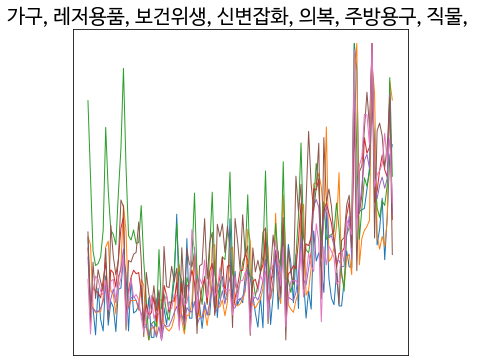

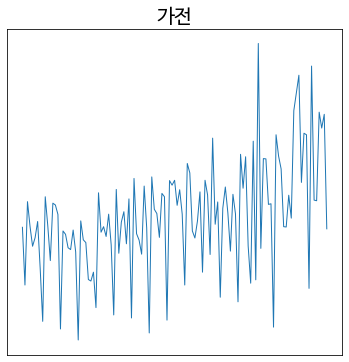

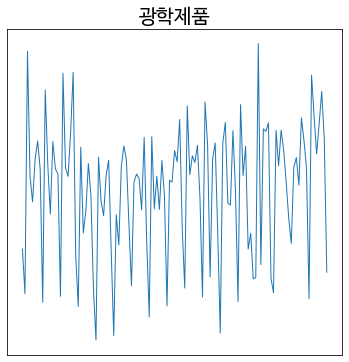

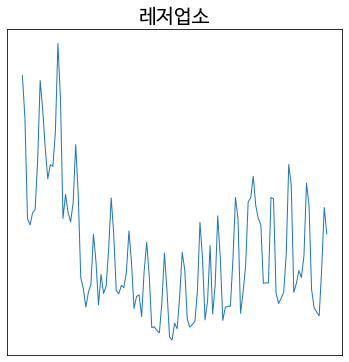

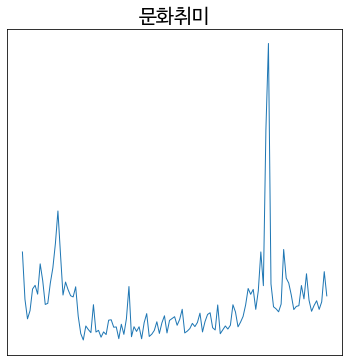

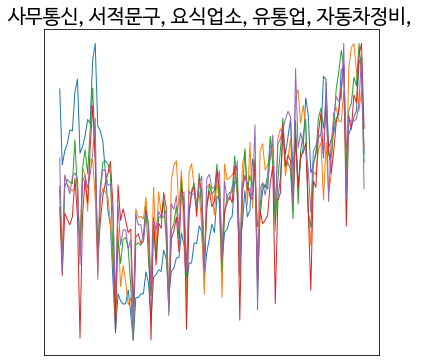

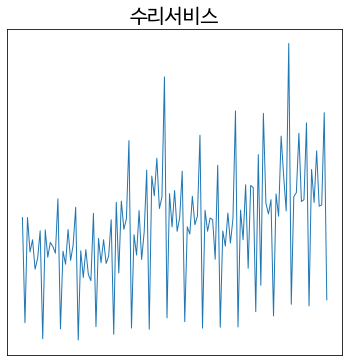

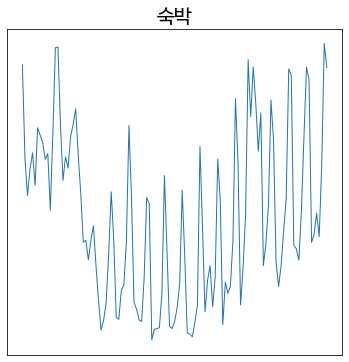

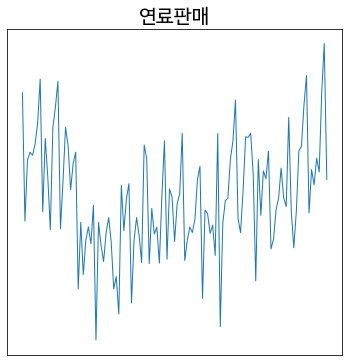

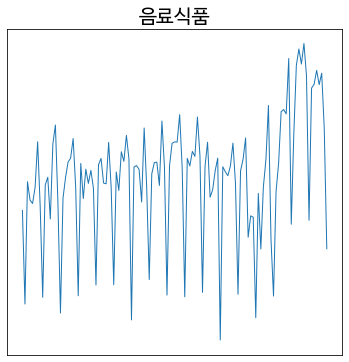

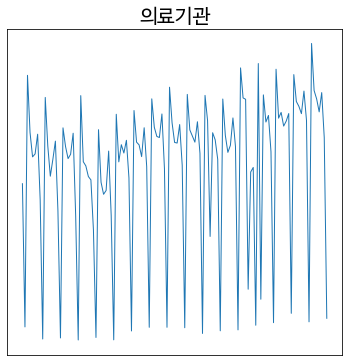

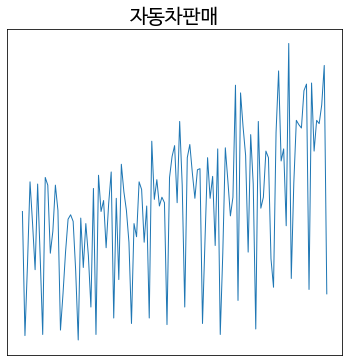

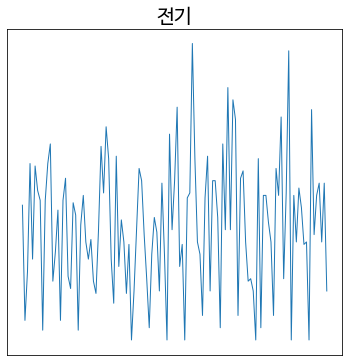

In [ ]:
n=cluster_result['DTW'].max()+1
for i in range(n):
  cluster = list(cluster_result.loc[cluster_result['DTW'] == i].업종)
  clustering_plot(cluster,sc_cnt_sum_20)

### **2. DTW rolling 3**

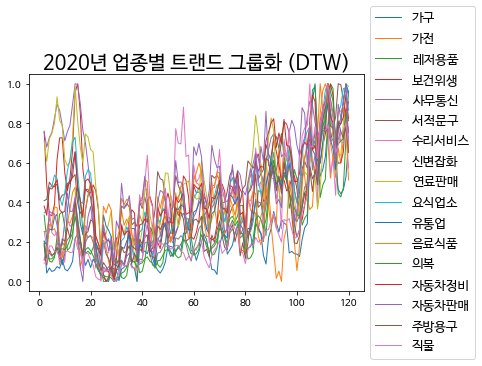

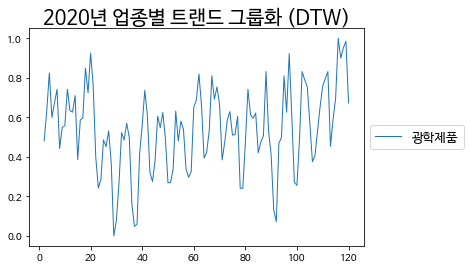

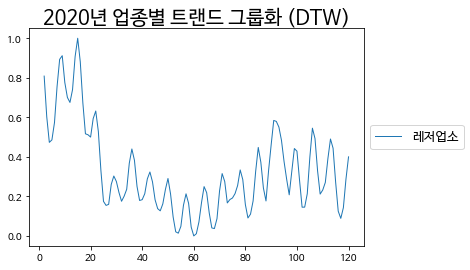

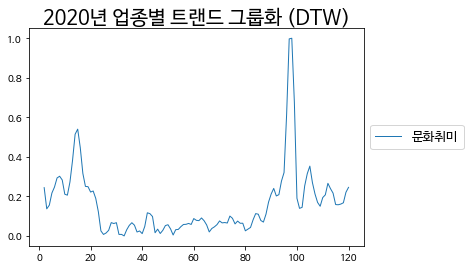

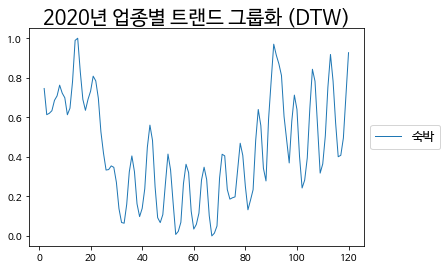

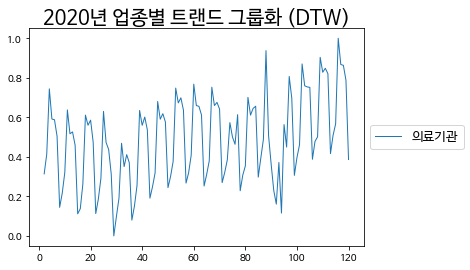

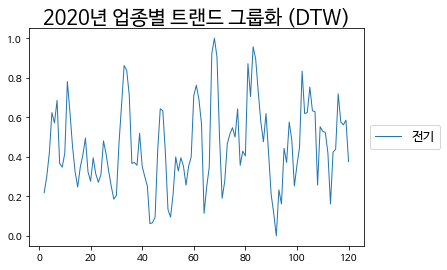

In [ ]:
n=cluster_result['DTW_roll3'].max()+1
for i in range(n):
  cluster = list(cluster_result.loc[cluster_result['DTW_roll3'] == i].업종)
  clustering_plot(cluster,sc_cnt_sum_20_roll3)

### **3. DTW rolling 5**

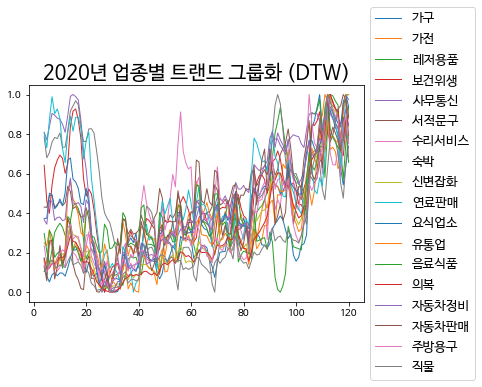

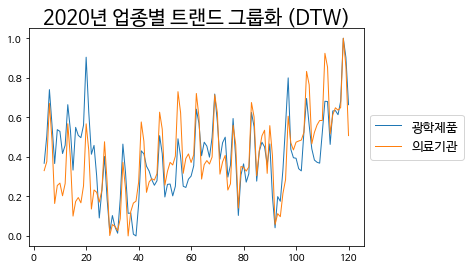

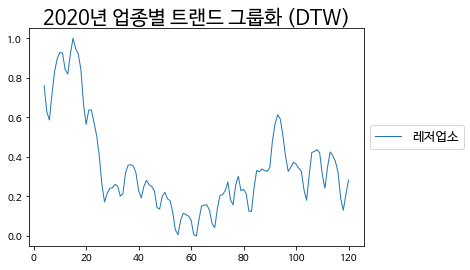

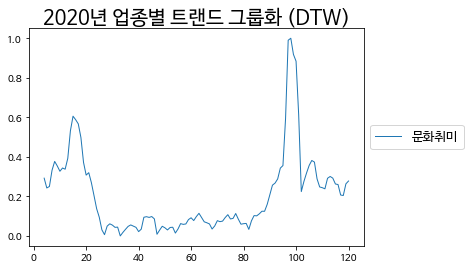

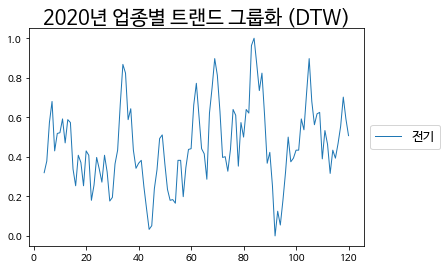

In [ ]:
n=cluster_result['DTW_roll5'].max()+1
for i in range(n):
  cluster = list(cluster_result.loc[cluster_result['DTW_roll5'] == i].업종)
  clustering_plot(cluster,sc_cnt_sum_20_roll5)

### **4. DTW rolling 7**

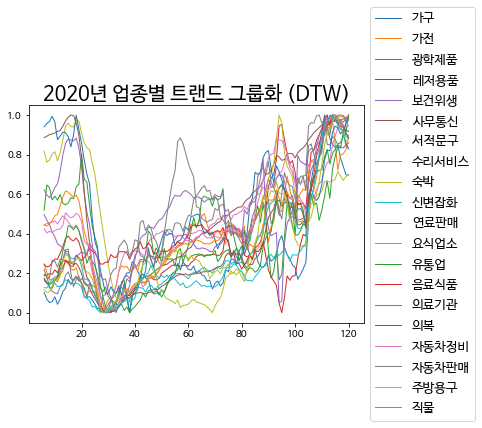

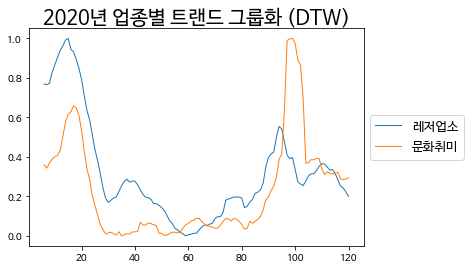

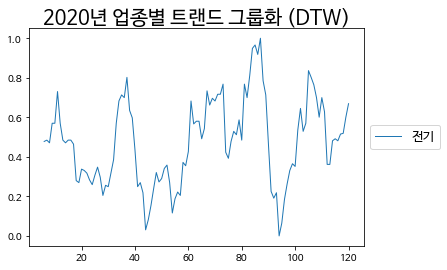

In [ ]:
n=cluster_result['DTW_roll7'].max()+1
for i in range(n):
  cluster = list(cluster_result.loc[cluster_result['DTW_roll7'] == i].업종)
  clustering_plot(cluster,sc_cnt_sum_20_roll7)

# **동별 업종 건수 summary**

In [ ]:
sc_cnt_dong= sc_cnt.groupby(['HDONG_NM']).sum()

In [ ]:
sc_cnt_dong

,가구,가전,광학제품,레저업소,레저용품,문화취미,보건위생,사무통신,서적문구,수리서비스,숙박,신변잡화,연료판매,요식업소,유통업,음료식품,의료기관,의복,자동차정비,자동차판매,전기,주방용구,직물
HDONG_NM,,,,,,,,,,,,,,,,,,,,,,,
공릉1동,1170.0,20877.0,1827.0,178246.0,18694.0,28787.0,104588.0,7105.0,25476.0,36696.0,12796.0,50192.0,423996.0,2163116.0,2881998.0,484988.0,777759.0,221641.0,120965.0,1002.0,2197.0,17027.0,35404.0
공릉2동,71.0,0.0,949.0,346511.0,10219.0,29413.0,131769.0,1002.0,76487.0,33231.0,578.0,2687.0,579045.0,1756341.0,2143432.0,447186.0,502979.0,4457.0,51237.0,150.0,1416.0,60.0,145.0
광희동,1749.0,726.0,8471.0,134871.0,126972.0,34664.0,187888.0,28134.0,45635.0,9868.0,41669.0,59629.0,12123.0,3157334.0,3579441.0,421055.0,505250.0,242515.0,320223.0,7757.0,203.0,795.0,3893.0
다산동,5297.0,1589.0,1330.0,101932.0,6615.0,118868.0,142605.0,1228.0,32163.0,23007.0,8559.0,7577.0,225531.0,1736572.0,4306696.0,406299.0,654219.0,24788.0,14268.0,479.0,18.0,545.0,2893.0
동화동,28.0,14292.0,548.0,122793.0,841.0,3765.0,64326.0,633.0,2176.0,15281.0,15306.0,2868.0,0.0,631067.0,1628209.0,264781.0,262819.0,13090.0,2665.0,981.0,1638.0,1913.0,2664.0
명동,0.0,24293.0,11701.0,124560.0,1551211.0,120139.0,521333.0,7585.0,232023.0,18189.0,84861.0,140356.0,271719.0,9591566.0,5415127.0,733555.0,1361552.0,496669.0,208206.0,0.0,684.0,4492.0,2718.0
상계10동,0.0,4296.0,28530.0,17494.0,2165.0,3822.0,26177.0,32.0,83037.0,629.0,0.0,3504.0,0.0,154733.0,357166.0,46695.0,8058.0,11264.0,807.0,0.0,8.0,0.0,49.0
상계1동,280.0,37805.0,2596.0,339430.0,23209.0,35449.0,211629.0,4006.0,50197.0,27585.0,3809.0,9142.0,456756.0,2018904.0,3487341.0,326412.0,589658.0,27832.0,32963.0,533.0,224.0,5055.0,3176.0
상계2동,2030.0,3198.0,14485.0,666319.0,67246.0,182247.0,360289.0,3800.0,64263.0,23537.0,39893.0,103670.0,204846.0,5149979.0,5442831.0,332050.0,738877.0,161435.0,46820.0,5824.0,25.0,6150.0,1528.0


위에 표에서 확인할 수 있듯, 지역에 해당업종이 존재하지 않는 경우들이 있어 데이터 bias를 일으킬 수 있음.

In [ ]:
sc_cnt_dong.loc[:,(sc_cnt_dong==0).any(axis=0)].describe()

,가구,가전,숙박,연료판매,자동차정비,자동차판매,전기,주방용구,직물
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,1062.529412,5977.941176,28754.323529,119433.764706,74081.029412,847.529412,297.852941,4685.205882,3165.911765
std,1564.147483,9653.880943,48771.903424,165788.286805,153821.225894,1604.241976,556.056305,9967.251160,6894.721153
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,23.000000,13.000000,0.000000,4135.250000,1.250000,5.750000,61.500000,285.750000
50%,235.500000,1589.000000,8559.000000,24173.500000,22007.000000,409.500000,42.000000,670.000000,1068.500000
75%,1613.250000,4715.000000,28998.500000,189764.000000,45136.000000,996.750000,245.750000,2398.250000,2792.250000
max,5297.000000,37805.000000,172398.000000,579045.000000,829608.000000,7757.000000,2197.000000,38858.000000,35404.000000
